# YOLO model evaluation on custom dataset

## The Dataset
The dataset is a simple video of a cctv footage of a high way road. It consists of a number of cars moving forward and backward in the road.

## Models evaluated
* Yolo
* Yolo-tiny

In [1]:
# Import what we need in this project
import argparse
import os
import cv2
import numpy as np
from tqdm import tqdm_notebook, tnrange
from matplotlib import pyplot as plt
import json
import pandas as pd
import seaborn as sns
from copy import deepcopy
import time

# Set seaborn color for precision-recall graph
sns.set_style('white')
sns.set_context('poster')
COLORS_BORN = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

# Set the random initialization seed for similar outcome every-time.
np.random.seed(42)

For evaluation yolo, set the model to 'yolo-coco'. And for yolo-tiny, set the model to 'yolo-tiny-tiny-coco'

In [2]:
model = 'yolo-coco'
CONFIDENCE = 0.5
THRESHOLD = 0.3

In [3]:
# load the COCO class labels the YOLO model was trained on
LABELS = open(model + '/coco.names').read().strip().split("\n")
print(LABELS)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [4]:
# initialize a list of colors to represent each possible class label
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
                           dtype="uint8")

# load our YOLO object detector trained on COCO dataset (80 classes)
net = cv2.dnn.readNetFromDarknet(model + '/config.cfg', model + '/weights.weights')
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [5]:
# Initialize the empty dictionary for accessing in loop as dictionary
cars = {}
bikes = {}
# loop in the dir
images = list(os.listdir('input_images'))
for i in tnrange(len(images), desc='Images processed : '):
    filename = images[i]
    
    # Ignore if the file is not a supported image
    if not (filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg")):
        continue
        
    # Initialize empty keys in the dictionary
    cars[filename] = {
        'boxes': [],
        'scores': []
    }
    bikes[filename] = {
        'boxes': [],
        'scores': []
    }

    image_path = cv2.imread('input_images/' + filename)
    (H, W) = image_path.shape[:2]

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image_path, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > CONFIDENCE:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs if they are car or bike
                if classID == 3 or classID == 2:
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE,
                            THRESHOLD)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            jbox = [x, y, x + w, y + h]

            # Use a proxy object 'clss' to check if the class is car or bike
            if classIDs[i] == 2:
                clss = cars
            elif classIDs[i] == 3:
                clss = bikes

            clss[filename]['boxes'].append(jbox)
            clss[filename]['scores'].append(confidences[i])
            
            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image_path, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image_path, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

#     plot the last output image
#     plt.imshow(image_path)

# Here are some of the output images of yolo
<img src="output/img_3.jpg" width="300"> <img src="output/img_5.jpg" width="300"> <img src="output/img_80.jpg" width="300"> <img src="output/img_93.jpg" width="300"> <img src="output/img_39.jpg" width="300"> <img src="output/img_8.jpg" width="300">

In [6]:
# Save the result as json file in the output folder
cars_json = json.dumps(cars)
bikes_json = json.dumps(bikes)
with open("output/cars.json", 'w') as f:
    f.write(cars_json)
with open("output/bikes.json", 'w') as f:
    f.write(bikes_json)
    
pd.read_json('output/cars.json')

,img_26.jpg,img_44.jpg,img_62.jpg,img_0.jpg,img_1.jpg,img_10.jpg,img_11.jpg,img_12.jpg,img_13.jpg,img_14.jpg,...,img_89.jpg,img_9.jpg,img_90.jpg,img_91.jpg,img_92.jpg,img_93.jpg,img_94.jpg,img_95.jpg,img_96.jpg,img_97.jpg
boxes,"[[646, 95, 693, 139], [736, 25, 763, 45], [619...","[[311, 25, 348, 48], [565, 106, 611, 145], [71...","[[384, 1, 418, 11], [687, 1, 713, 9], [714, 39...","[[317, 32, 364, 68], [285, 12, 327, 37], [785,...","[[256, 53, 310, 88], [774, 48, 809, 75], [67, ...","[[608, 25, 641, 48], [732, 60, 771, 90], [544,...","[[560, 25, 596, 50], [730, 41, 762, 71], [491,...","[[522, 63, 570, 99], [571, 14, 601, 34], [614,...","[[643, 172, 708, 229], [653, 75, 696, 112], [7...","[[753, 131, 813, 184], [565, 26, 591, 47], [65...",...,"[[652, 57, 686, 87], [601, 24, 633, 47], [388,...","[[600, 38, 639, 63], [521, 55, 570, 96], [629,...","[[652, 38, 686, 63], [427, 13, 463, 35], [365,...","[[657, 26, 686, 46], [189, 38, 241, 70], [332,...","[[556, 127, 609, 174], [105, 59, 170, 96], [18...","[[649, 161, 710, 216], [293, 61, 357, 102], [7...","[[399, 30, 429, 57], [739, 129, 799, 178], [16...","[[555, 115, 608, 155], [62, 92, 139, 132], [65...","[[289, 74, 343, 109], [659, 59, 695, 89], [722...","[[195, 111, 270, 159], [551, 122, 605, 168], [..."
scores,"[0.976247906684875, 0.968871533870697, 0.95910...","[0.992325007915496, 0.9907867908477781, 0.9797...","[0.7347724437713621, 0.628587186336517, 0.6067...","[0.9823917746543881, 0.9807271957397461, 0.979...","[0.9834737777709961, 0.977347016334533, 0.9746...","[0.989284873008728, 0.9737091064453121, 0.9723...","[0.986136019229888, 0.9776474833488461, 0.9753...","[0.97266674041748, 0.9568907022476191, 0.95623...","[0.9915751218795771, 0.9778193235397331, 0.973...","[0.990289270877838, 0.9833600521087641, 0.9666...",...,"[0.9794237017631531, 0.9751981496810911, 0.957...","[0.9942184090614311, 0.9770568013191221, 0.975...","[0.9884975552558891, 0.9686204791069031, 0.947...","[0.9879177212715141, 0.983616471290588, 0.9820...","[0.9948987364768981, 0.9922372698783871, 0.990...","[0.9944413304328911, 0.9887120127677911, 0.983...","[0.9914358258247371, 0.991029977798461, 0.9881...","[0.9896192550659181, 0.9874929189682001, 0.987...","[0.9835268855094911, 0.9764318466186521, 0.966...","[0.9855775833129881, 0.9799593091011041, 0.963..."


According to [Darknet](https://pjreddie.com/darknet/yolo/), the format of the annotation of the images should be like this:
```
<object-class> <x> <y> <width> <height>
```
So we convert to this format from the json files.

In [7]:
def run(cars="output/cars.json", bikes="output/bikes.json", output='.'):
    with open(cars) as file:
        car_data = json.load(file)
    with open(bikes) as file:
        bike_data = json.load(file)
    for img, d in car_data.items():
        lines = []
        if not d:
            continue
        for box in d['boxes']:
            
            xmin, ymin, xmax, ymax = box
            nam = 'car'
            lines.append([nam, str(xmin), str(ymin), str(xmax), str(ymax)])

        lines_str = [" ".join(lines[i]) for i in range(len(lines))]
        lines = "\n".join(lines_str[i] for i in range(len(lines_str)))
        with open(output + '/yolo_labels/' + img[:-4] + '.txt', 'w') as label_file:
            label_file.write(lines)

    for img, d in bike_data.items():
        if not d:
            continue
        lines = []
        for box in d['boxes']:
            xmin, ymin, xmax, ymax = box
            nam = 'bike'

            lines.append([nam, str(xmin), str(ymin), str(xmax), str(ymax)])

        lines_str = [" ".join(lines[i]) for i in range(len(lines))]
        lines = "\n".join(lines_str[i] for i in range(len(lines_str)))
        with open(output + '/yolo_labels/' + img[:-4] + '.txt', 'a') as label_file:
            label_file.write(lines)
            
run(output='output')
print('Sample "img_5.txt" file :')
with open('output/yolo_labels/img_5.txt', 'r') as f:
    print(f.read())

Sample "img_5.txt" file :
car 284 42 333 82
car 532 167 601 233
car 639 274 734 359
car 739 11 768 25
car 859 390 1014 538
car 651 85 691 121
car 741 78 780 112
car 651 9 684 28
car 131 376 343 551
car 613 3 639 13
car 485 1 515 10
car 4 81 85 127
car 718 1 743 14


### Conversion of labelbox labels to our json format.
We have labeled our dataset on [LabelBox](https://labelbox.com). The format we have downloaded is type 'json', label format 'XY', and without any MASK.

In [8]:
with open('ground_truth_boxes/labelbox.json') as f:
    data = json.load(f)

car_output = {}
bike_output = {}

for i in data:
    car_boxes = []
    bike_boxes = []
    img = i["External ID"]
    labels = i["Label"]
    if "Car" in labels:
        for boxes in labels["Car"]:
            bboxes = boxes["geometry"]
            xmin = min([x['x'] for x in bboxes])
            ymin = min([x['y'] for x in bboxes])
            xmax = max([x['x'] for x in bboxes])
            ymax = max([x['y'] for x in bboxes])
            car_boxes.append([xmin, ymin, xmax, ymax])
    if "Bike" in labels:
        for boxes in labels["Bike"]:
            bboxes = boxes["geometry"]
            xmin = min([x['x'] for x in bboxes])
            ymin = min([x['y'] for x in bboxes])
            xmax = max([x['x'] for x in bboxes])
            ymax = max([x['y'] for x in bboxes])
            bike_boxes.append([xmin, ymin, xmax, ymax])

    car_output[img] = car_boxes
    bike_output[img] = bike_boxes

car_json = json.dumps(car_output)
bike_json = json.dumps(bike_output)
with open("ground_truth_boxes/cars.json", 'w') as f:
    f.write(car_json)
with open("ground_truth_boxes/bikes.json", 'w') as f:
    f.write(bike_json)

Note : As there are no bike images in the dataset, the graph for bikes will be blank.


For bikes.json : 
Single IoU calculation took 0.0034 secs
avg precision for bikes.json: 0.0000
mAP: 0.00
avg precs:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 0.0756 secs


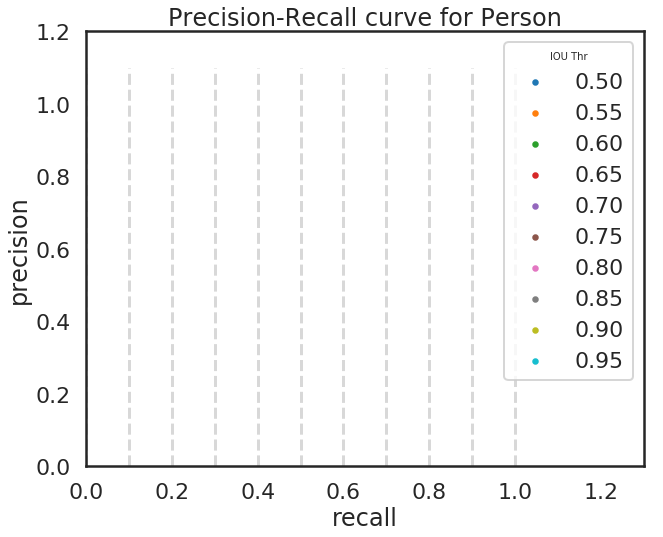




For cars.json : 
Single IoU calculation took 0.1771 secs
avg precision for cars.json: 0.5580
mAP: 40.00
avg precs:  [0.6789, 0.6776, 0.6648, 0.6034, 0.558, 0.3904, 0.2628, 0.129, 0.0336, 0.0012]
iou_thrs:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

Plotting and calculating mAP takes 1.8777 secs


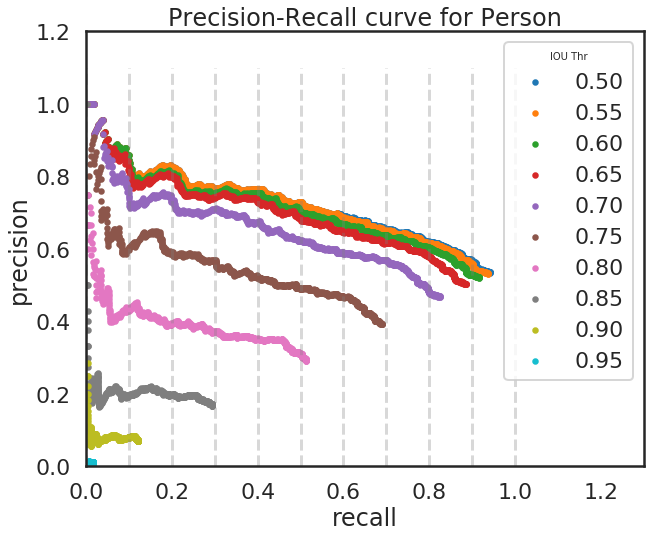




Cars matrix :  {'tp': 525, 'tn': 0, 'fp': 450, 'fn': 28}
Bikes matrix :  {'tp': 0, 'tn': 525, 'fp': 0, 'fn': 0}


In [9]:
def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box

    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]

    Returns:
        float: value of the IoU for the two boxes.

    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t:
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    # current_class['tp'] += tp
    # current_class['fn'] += fn
    # current_class['fp'] += fp

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}


def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images

    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }

    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0
    false_pos = 0
    false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos / (true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos / (true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    # current_class['tp'] = sum([i['true_pos'] for i in img_results.values()])
    # current_class['fp'] = sum([i['false_pos'] for i in img_results.values()])
    # current_class['fn'] = sum([i['false_neg'] for i in img_results.values()])

    return precision, recall


def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map


def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    done = False
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    # pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        if model_score_thr >= confidence_thrs and not done:
            done = True
            current_class['tp'] = sum(i['true_pos'] for i in img_results.values())
            current_class['fp'] = sum(i['false_pos'] for i in img_results.values())
            current_class['fn'] = sum(i['false_neg'] for i in img_results.values())
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def plot_pr_curve(
        precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()

    if color is None:
        color = COLORS_BORN[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0, 1.3])
    ax.set_ylim([0.0, 1.2])
    return ax


confidence_thrs = 0.5
cars_mat = {
    'tp': 0,
    'tn': 0,
    'fp': 0,
    'fn': 0
}
bike_mat = {
    'tp': 0,
    'tn': 0,
    'fp': 0,
    'fn': 0
}

print("Note : As there are no bike images in the dataset, the graph for bikes will be blank.\n\n")
for filename in os.listdir("ground_truth_boxes"):
    if filename == 'cars.json':
        current_class = cars_mat
    elif filename == 'bikes.json':
        current_class = bike_mat

    if filename in ['labelbox.json', 'yolo_labels']:
        continue
    with open('ground_truth_boxes/' + filename) as infile:
        gt_boxes = json.load(infile)

    with open('output/' + filename) as infile:
        pred_boxes = json.load(infile)

    print('For ' + filename + " : ")
    
    # Runs it for one IoU threshold
    start_time = time.time()
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.7)
    end_time = time.time()
    print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
    
    print('avg precision for {}: {:.4f}'.format(filename, data['avg_prec']))

    start_time = time.time()
    ax = None
    avg_precs = []
    iou_thrs = []
    for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
        data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']
        ax = plot_pr_curve(
            precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS_BORN[idx * 2], ax=ax)

    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    print('mAP: {:.2f}'.format(100 * np.mean(avg_precs)))
    print('avg precs: ', avg_precs)
    print('iou_thrs:  ', iou_thrs)
    plt.legend(loc='upper right', title='IOU Thr', frameon=True)
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
    end_time = time.time()
    print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
    plt.savefig('output/' + filename + '_mAP.png')
    plt.show()
    print('')
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.2)
    print()
    print()

cars_mat['tn'] = bike_mat['tp']
bike_mat['tn'] = cars_mat['tp']
print('Cars matrix : ', cars_mat)
print('Bikes matrix : ', bike_mat)